In [12]:
from elasticsearch import Elasticsearch
import json

In [18]:
light_links = {}
for line in file('light_link.txt').readlines():
    nid, links = line.strip().split("\t")
    light_links[nid] = links.split(",")

In [41]:
date = '20170321'
time = '0725'
timestamp = date + time

In [13]:
es = Elasticsearch([{'host': '192.168.86.58', 'port': 9200}])#,
#                        sniff_on_start=True,
#                        sniff_on_connection_fail=True,
#                        sniffer_timeout=60)

In [162]:
top100 = es.search(index='hefei-lukuang-gaode', doc_type='lukuang', body={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "status:>2",
          "analyze_wildcard": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": 1494125697509,
                  "lte": 1496717697509,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "hour": {
      "terms": {
        "field": "hour",
        "size": 7,
        "order": {
          "_term": "asc"
        }
      },
      "aggs": {
        "weekday": {
          "terms": {
            "field": "weekday",
            "size": 7,
            "order": {
              "_term": "asc"
            }
          },
          "aggs": {
            "link": {
              "terms": {
                "field": "link",
                "size": 100,
                "order": {
                  "_count": "desc"
                }
              }
            }
          }
        }
      }
    }
  }
})

In [164]:
top100

{u'_shards': {u'failed': 0, u'successful': 4, u'total': 4},
 u'aggregations': {u'hour': {u'buckets': [{u'doc_count': 33073,
     u'key': 7,
     u'weekday': {u'buckets': [{u'doc_count': 1682,
        u'key': 1,
        u'link': {u'buckets': [{u'doc_count': 10, u'key': u'160163'},
          {u'doc_count': 10, u'key': u'49510695'},
          {u'doc_count': 10, u'key': u'87598954'},
          {u'doc_count': 8, u'key': u'140266'},
          {u'doc_count': 8, u'key': u'39335248'},
          {u'doc_count': 6, u'key': u'15028194'},
          {u'doc_count': 6, u'key': u'169349'},
          {u'doc_count': 6, u'key': u'201897'},
          {u'doc_count': 6, u'key': u'224048'},
          {u'doc_count': 6, u'key': u'39335244'},
          {u'doc_count': 6, u'key': u'49510811'},
          {u'doc_count': 6, u'key': u'49510815'},
          {u'doc_count': 5, u'key': u'12546286'},
          {u'doc_count': 5, u'key': u'136574'},
          {u'doc_count': 5, u'key': u'139887'},
          {u'doc_count': 5, u

In [50]:
index = "hefei-traffic-"+date
itype = 'segmentSpeed'
res = es.search(index=index, doc_type=itype, size=1000, body={
            "query": {
                "bool": {
                    "must": [{
                        "match": {
                            "timestamp": {
                                "query": timestamp,
                                "type": "phrase"
                            }
                        }
                    }, {
                        "term": {
                            "status": 3
                        }
                    }]
                }
            },
            "_source": {
                "includes": [
                    "status",
                    "node_pair",
                    "link"
                ],
                "excludes": []
            }
        })

In [51]:
def query_link_body(links, timestamp):
    return {
            "query": {
                "filtered" : {
                  "filter" : {
                    "bool": {
                            "must": [{
                                "match": {
                                    "timestamp": {
                                        "query": timestamp,
                                        "type": "phrase"
                                    }
                                }
                            },{
                            "terms" : {
                              "link" : links
                            }
                          }]
                    }
                  },
                  "query": {
                    "terms" : {
                      "link" : links
                    }
                  }
                }
            },
            "_source": {
                "includes": [
                    "status",
                    "link"
                ],
                "excludes": []
            }
        }

In [52]:
for r in res['hits']['hits']:
    node_pair = r['_source']['node_pair']
    node1, node2 = node_pair.split('-')
    links = light_links.get(node1, []) + light_links.get(node2, [])
    if len(links) > 0:
        print ','.join([node1, node2])
        print ','.join(links)
        status = es.search(index="hefei-traffic-"+date, doc_type="segmentSpeed", size=1000, 
                           body = query_link_body(links, timestamp))
        result = []
        for s in status['hits']['hits']:
            result.append(s['_source']['link'] + '|' + str(s['_source']['status']))
        print ','.join(result)      

250676,250671
182512,49510879,85106564,192858,192860,49510878,49510879,182514,182515,49510878
182514|3,182515|3,85106564|1,85106564|1,182512|1
214389,72856041
224407,224412,85349500,85349502,95643319,224407,224408,224420,49552829,85429060
85349502|3,85349502|3,95643319|2
250642,250676
182512,49510879,85106564,192858,192860,49510878,49510879,182514,182515,49510878
182514|3,182515|3,85106564|1,85106564|1,182512|1
214389,72856041
224407,224412,85349500,85349502,95643319,224407,224408,224420,49552829,85429060
85349502|3,85349502|3,95643319|2
119884,112529
150477,150478,150479,87578876,137357,137359,138039,150477
137357|3,150479|1,137359|1,137359|1,87578876|1,87578876|1


## 高德

In [61]:
date = '20170518'
time = '0850'
timestamp = date + time

In [62]:
# index = "hefei-traffic-"+date
index = 'hefei-lukuang-gaode-sample'
itype = 'lukuang'
res = es.search(index=index, doc_type=itype, size=1000, body={
            "query": {
                "bool": {
                    "must": [{
                        "match": {
                            "timestamp": {
                                "query": timestamp,
                                "type": "phrase"
                            }
                        }
                    }, {
                        "term": {
                            "status": 3
                        }
                    }]
                }
            },
            "_source": {
                "includes": [
                    "status",
                    "tile_str",
                    "link"
                ],
                "excludes": []
            }
        })

In [26]:
def query_tile_body(tiles, timestamp):
    return {
            "query": {
                "filtered" : {
                  "filter" : {
                    "bool": {
                            "must": [{
                                "match": {
                                    "timestamp": {
                                        "query": timestamp,
                                        "type": "phrase"
                                    }
                                }
                            },{
                            "terms" : {
                              "tile" : tiles
                            }
                          }]
                    }
                  },
                  "query": {
                    "terms" : {
                      "tile" : tiles
                    }
                  }
                }
            },
            "_source": {
                "includes": [
                    "status",
                    "link"
                ],
                "excludes": []
            }
        }

## 根据瓦片查路况

In [168]:
# for r in res['hits']['hits']:
#     tiles = r['_source']['tile_str'].split(',')
#     if len(tiles) > 0:
        
status = es.search(index='hefei-lukuang-gaode', doc_type='lukuang', size=1000, 
                   body = query_tile_body(['108246_53288','108247_53288','108245_53288', '108248_53288','108247_53288'], '201705311920'))
result = []
for s in status['hits']['hits']:
    result.append(s['_source']['link'] + '|' + str(s['_source']['status']))
print '*' * 20
print ','.join(result)

********************
85349959|1,185284|1,185284|1,185287|3,185287|3,19628416|4,49511026|1,87599452|1,140863|1,49510655|1,19628415|4,91855990|3,49511027|1,87599453|1,91855987|4,91855989|3,91855984|1,177821|1,171734|1,171730|1,171734|1,177823|1,39218153|1,85349960|1,87599440|1,39334831|1,39334832|1,140072|1,192828|1,87599445|1,15027977|1,39334937|1,186990|1,140070|1,15027830|1,15027976|1,187001|1,15027831|1,186998|1,39334935|1,39334933|1


## 根据路口查询所有关联link

In [153]:
import pandas as pd
links = pd.read_csv("jam.csv", dtype={'link': str, 'timestamp': str, 'light_node': str})
jam_file = file("jam_link.csv", "w")

for i, v in links.iterrows():
#     print v['link'], v['light_node'], v['timestamp']
    res = es.search(index='hefei-lukuang-gaode-peak', doc_type='lukuang', size=1000, body={
            "from": 0,
            "size": 200,
            "query": {
                "bool": {
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "match": {
                                        "light_node": {
                                            "query": v['light_node'],
                                            "type": "phrase"
                                        }
                                    }
                                },
                                {
                                    "match": {
                                        "timestamp": {
                                            "query": v['timestamp'],
                                            "type": "phrase"
                                        }
                                    }
                                }
                            ]
                        }
                    }
                }
            }
        })

    result = []
    for s in res['hits']['hits']:
        result.append(s['_source']['link'] + '|' + str(s['_source']['status']))
    print '*' * 20
    jam_file.write(v['light_node'] + "\t" + ','.join(result) + "\n")

jam_file.close()
    

********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
********************
*************

In [152]:
res = es.search(index='hefei-lukuang-gaode-peak', doc_type='lukuang', size=1000, body={
            "from": 0,
            "size": 200,
            "query": {
                "bool": {
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "match": {
                                        "light_node": {
                                            "query": '164282',
                                            "type": "phrase"
                                        }
                                    }
                                },
                                {
                                    "match": {
                                        "timestamp": {
                                            "query": '201705221915',
                                            "type": "phrase"
                                        }
                                    }
                                }
                            ]
                        }
                    }
                }
            }
        })

result = []
for s in res['hits']['hits']:
    result.append(s['_source']['link'] + '|' + str(s['_source']['status']))
print '*' * 20
print ','.join(result)

********************
39325826|1,87594957|1,87594972|1,39325823|1,87594953|1,87594951|1,87594952|1


In [154]:
from IPython.display import FileLink
FileLink('jam_link.csv')

/home/zhli7/lukuang/jam_link.csv

## 显示高德路况图片

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mimg
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

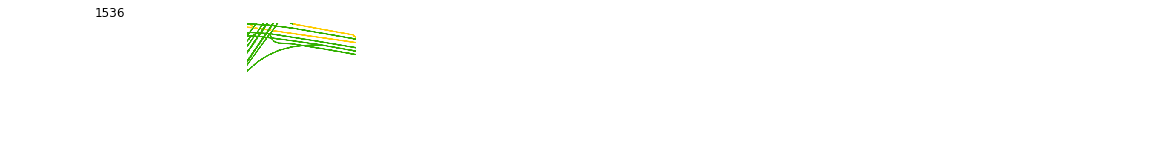

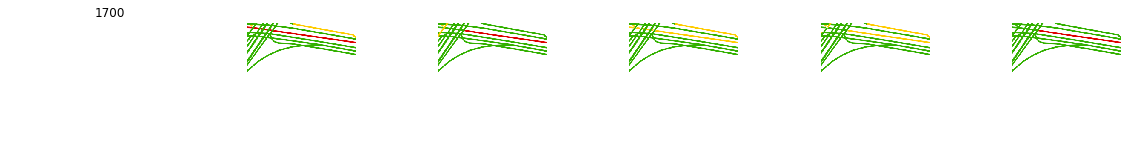

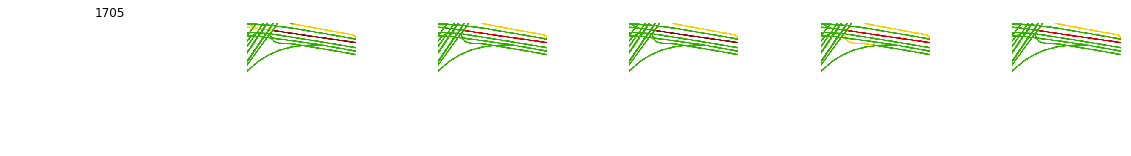

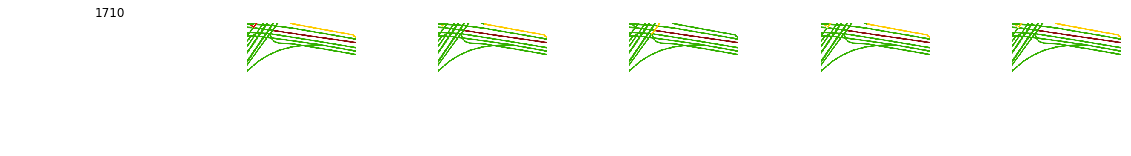

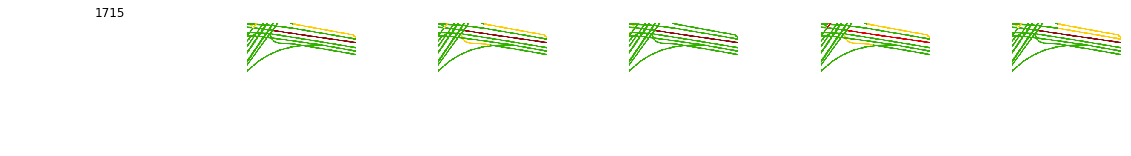

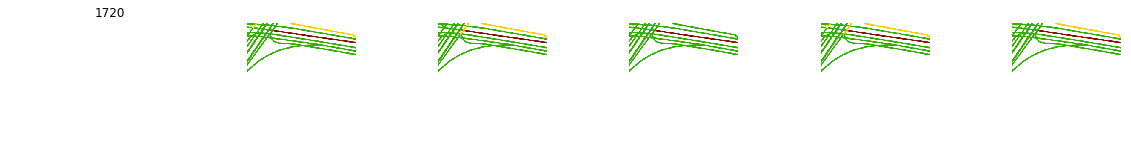

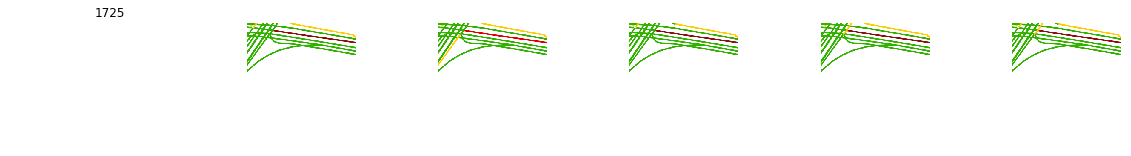

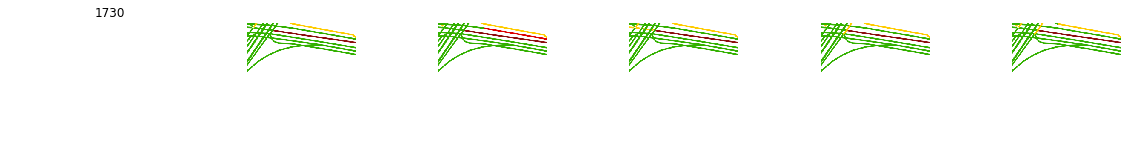

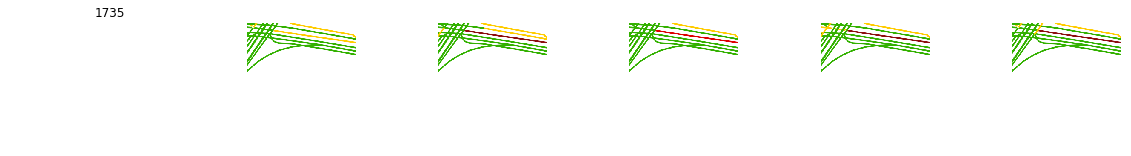

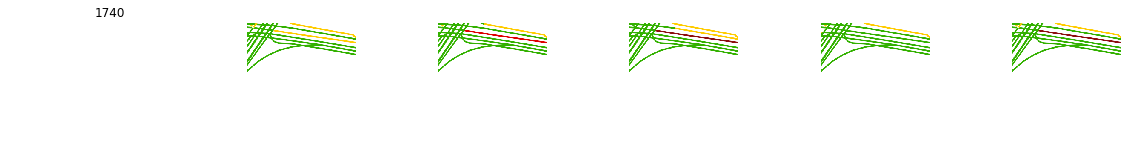

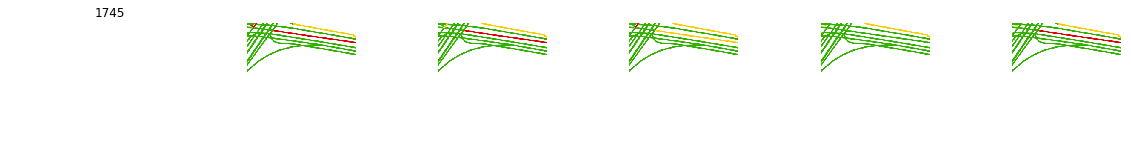

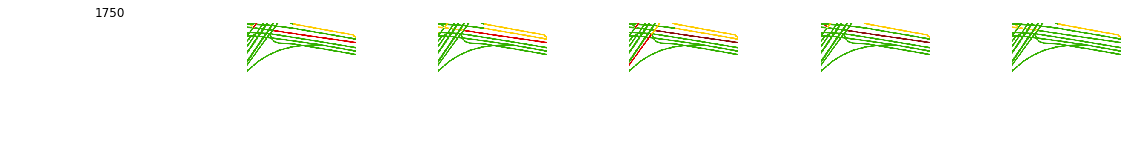

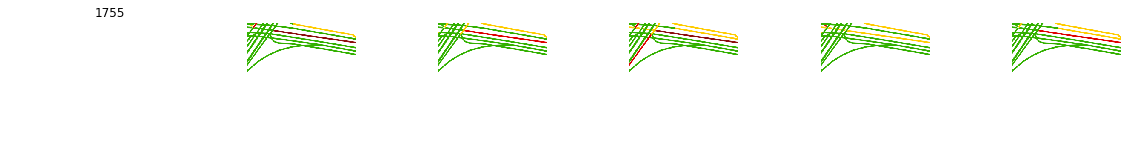

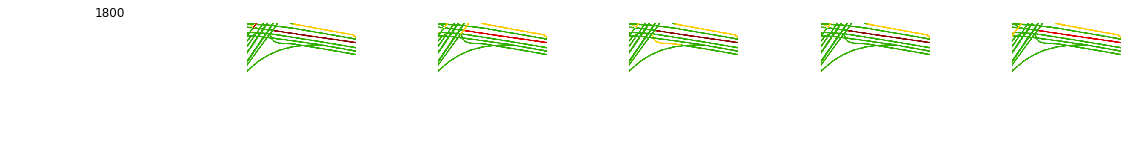

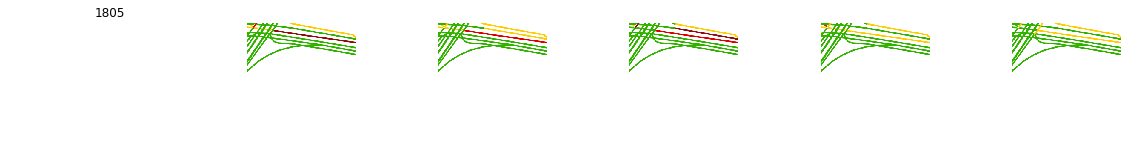

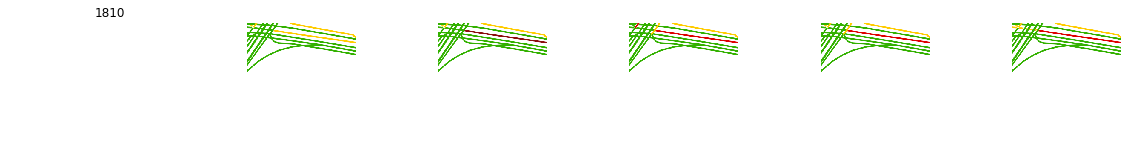

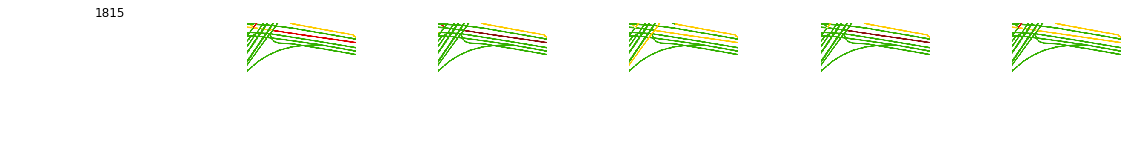

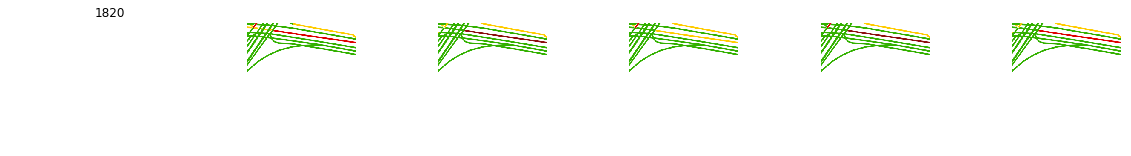

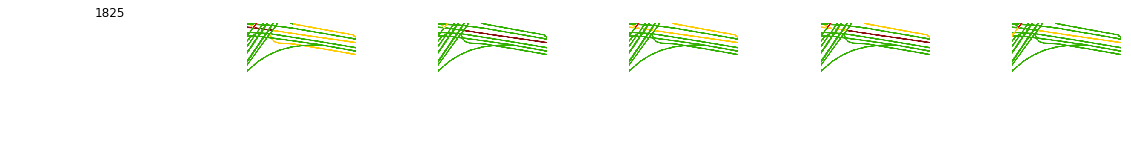

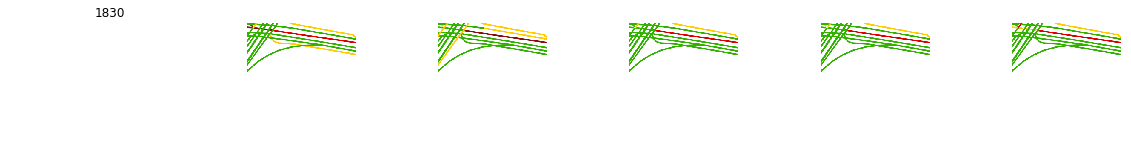

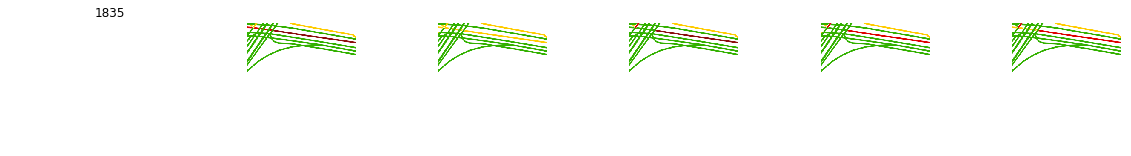

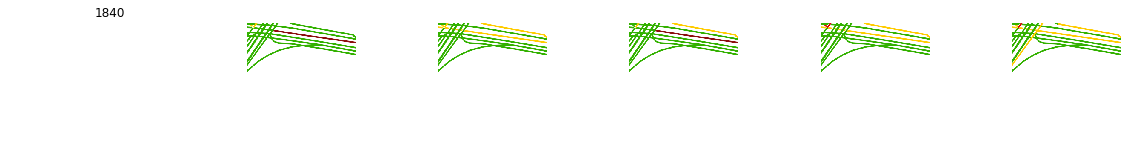

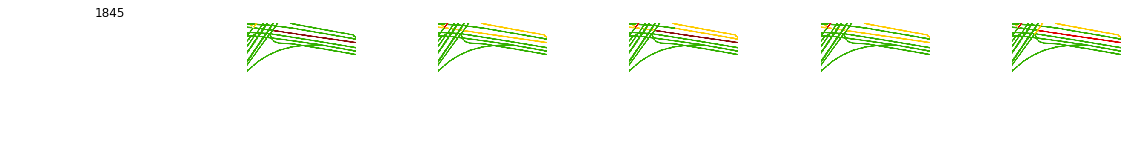

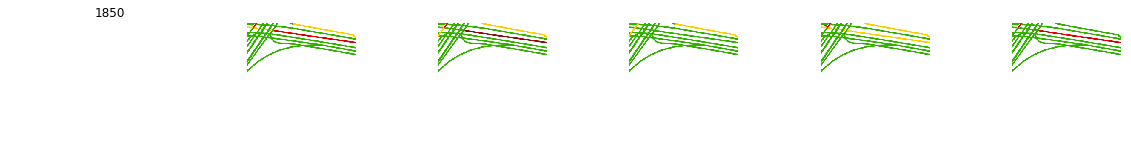

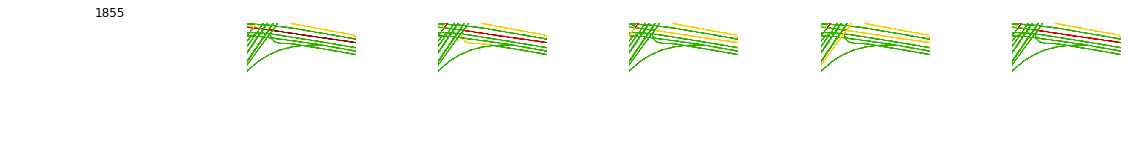

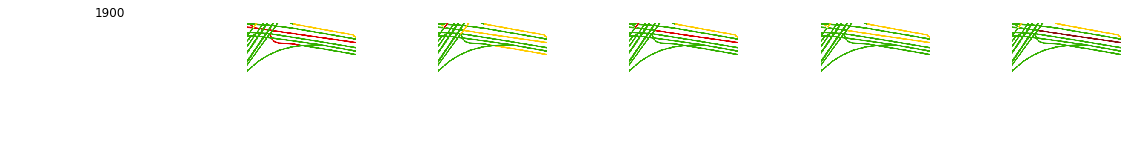

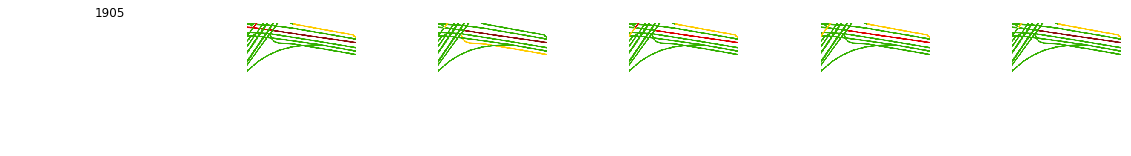

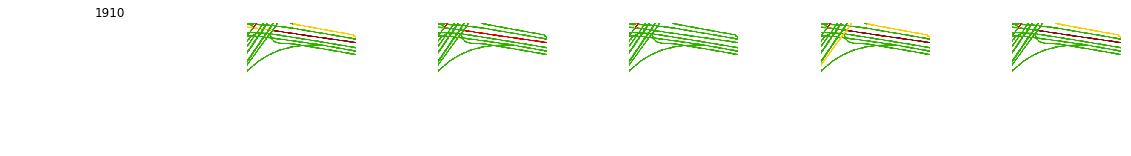

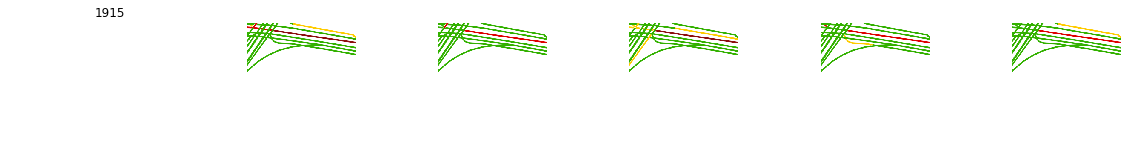

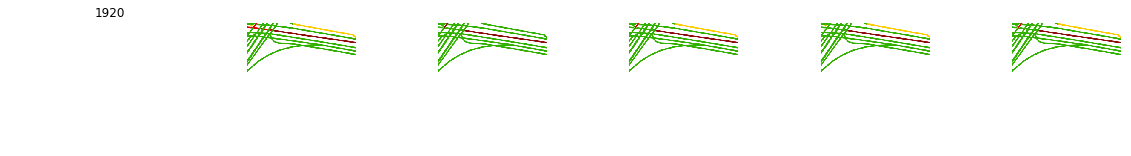

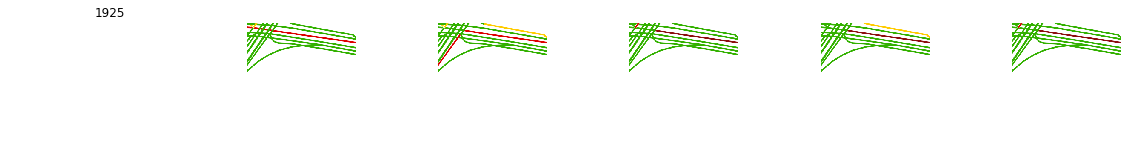

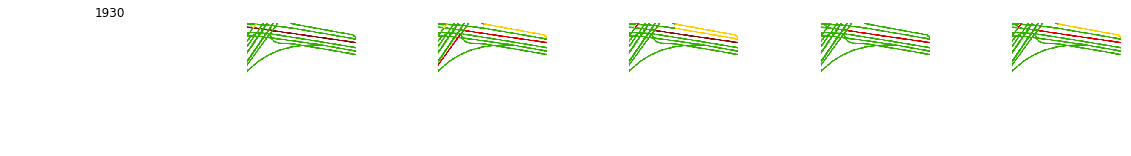

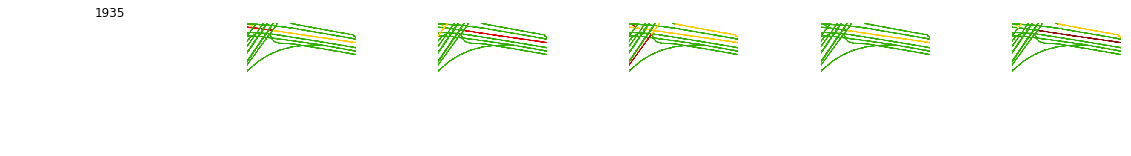

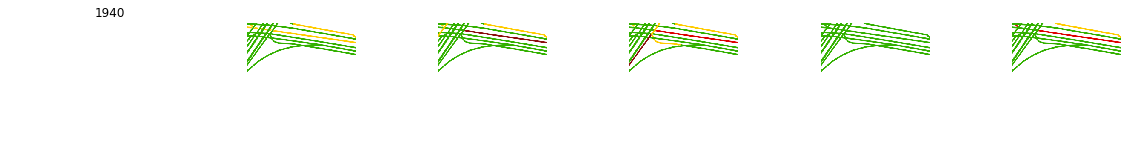

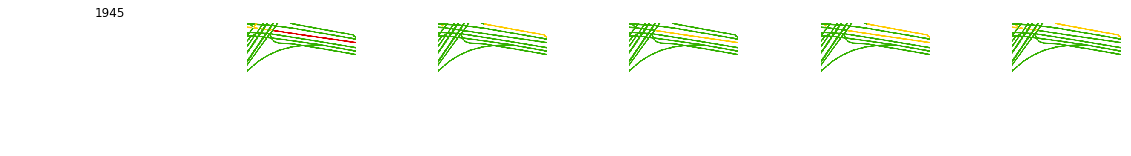

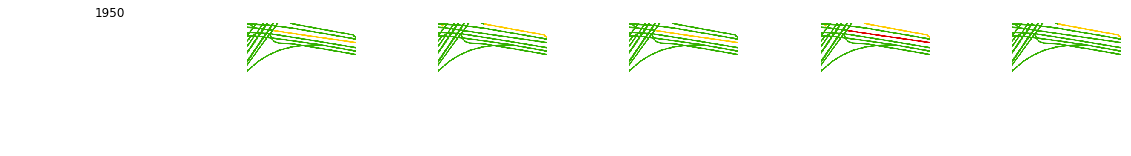

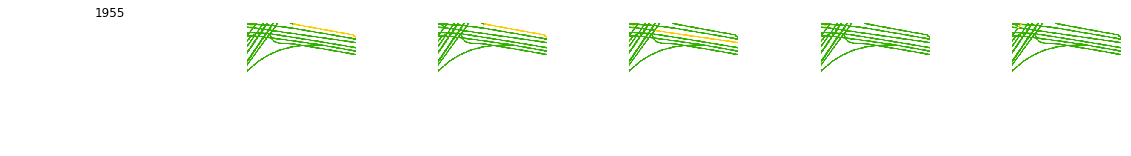

In [10]:
import glob
tile = '108227_53306'
root = 'gaode_pic/'+tile+'/'
images = glob.glob(root + '*.png')
days = set()
times = set()
for path in images:
    # path like 'gaode/108241_53286/108241_53286_201705221845.png'
    dt = path.split('/')[-1].split('_')[-1].rstrip('.png')
    days.add(dt[:8])
    times.add(dt[8:])

for ti, time in enumerate(sorted(times)):
    if time < '1200':
        continue
    plt.figure(figsize=(20, 2))
    plt.subplot(1, len(days) + 1, 1)
    plt.title(time)
    plt.axis('off')
    for di, day in enumerate(sorted(days)):
#         plt.subplot(len(days), len(times), ti * len(days) + di + 1)
        plt.subplot(1, len(days) + 1, di + 2)
        try:
            img = mimg.imread(root + tile + '_' + day + time + '.png')
            plt.imshow(img)
        except:
            pass
        plt.axis('off')
        if ti == 0:
            plt.title(day)

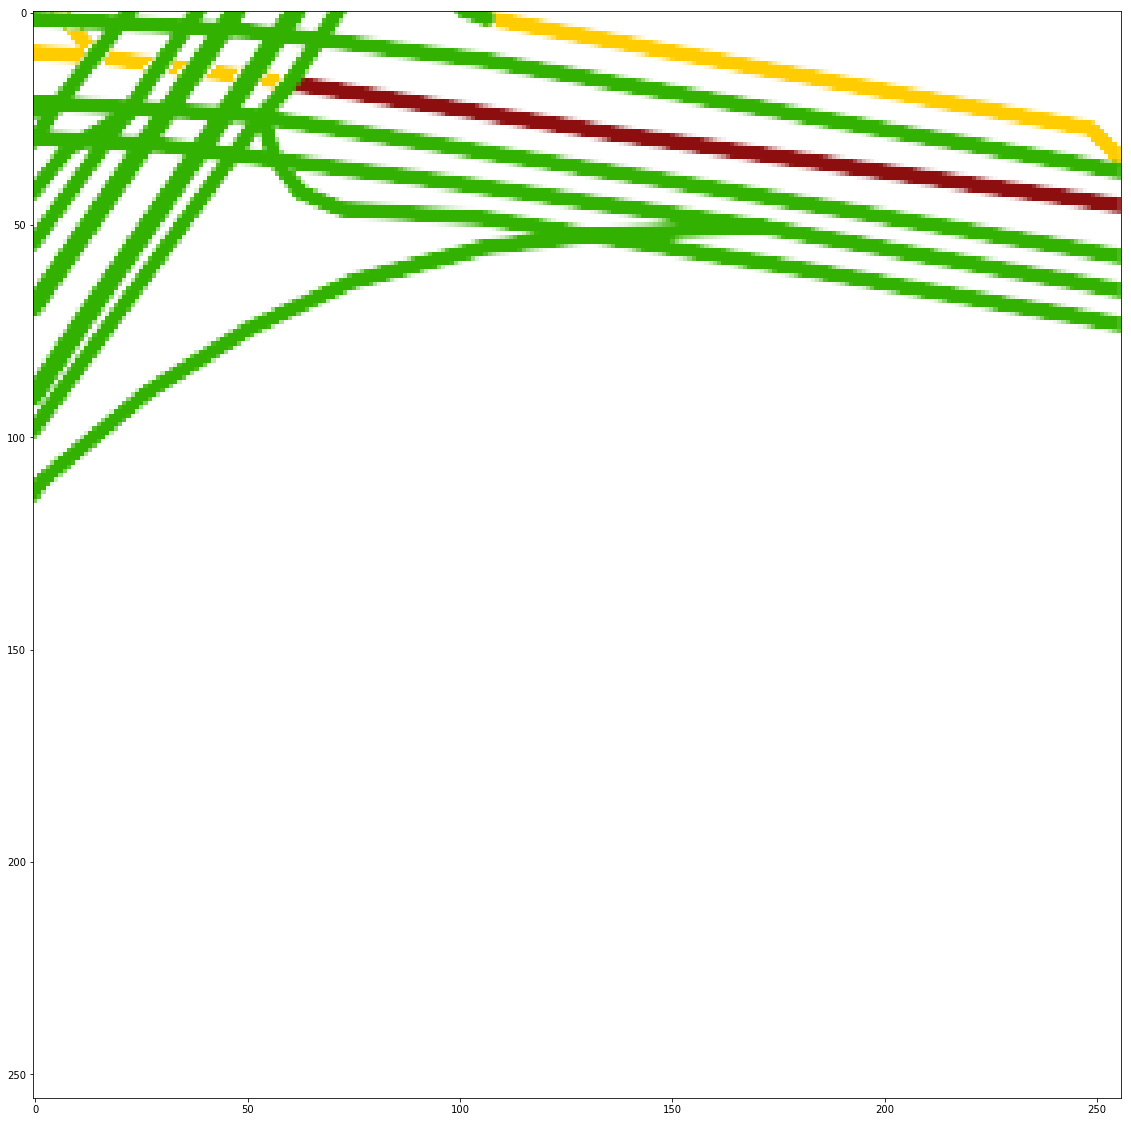

In [16]:
img = mimg.imread(root + tile + '_' + '20170521' + '1705' + '.png')
plt.imshow(img)